In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples, homogeneity_completeness_v_measure
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

In [2]:
metric_names = ['Silhouette Coefficients ', 'Average Silhouette Metric ', 'Scaled Multiplied Silhouette Metric ']
radio_classes = [0, 1, 2, 3]
radio_names = ['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'All Radiologists Agree']
scale = preprocessing.MinMaxScaler()

In [3]:
def cluster_centroid(embeddings, y_sc, numclusters):
    centroids = [] #center indice values
    for i in range(numclusters): #for each class...
        inds = np.where(y_sc==i)[0]#list of all images within the same proposed class
        print(inds)
        inds_embed = embeddings[inds] #feature vectors of all these images
        inds_embed1 = np.array(inds_embed) #numpy array of this matrix
        column_mean = inds_embed1.mean(axis=0) #mean per dimension (x, y, z, etc.)
        centroids.append(column_mean) #append to the list
    return centroids

In [4]:
def wss(centroids, embeddings, y_sc, numclusters, n): #in 2d - total wss (not average)
    wss_percluster = [] # list of total distance per class
    closest_inds = []
    farthest_inds = []
    for i in range(numclusters):
        inds = np.where(y_sc==i)[0] #list of all images within the same proposed class
        inds_embed = embeddings[inds] #feature vectors of all these images
        inds_embed1 = np.array(inds_embed) #numpy array of this matrix
        after_subtraction = inds_embed1 - centroids[i] #subtracting the centroid indices from the image indices
        squared_matrix = np.square(after_subtraction) #square the distance values
        sum_rows = np.sum(squared_matrix, axis = 1) #add all fo the distances of the same image 
        sum_cols = np.sum(sum_rows) #add all of image distances together of the same class 
        wss_percluster.append(sum_cols) #include this in the total distances per class
        ## find the images farthest/closest to centroid
        indclosest = np.argpartition(sum_rows, n)[:n]
        indfarthest = np.argpartition(sum_rows, -n)[-n:]
        indclosestnum = inds[indclosest]
        indfarthestnum = inds[indfarthest]
        closest_inds.append(indclosestnum)
        farthest_inds.append(indfarthestnum) #final image number
    tot_wss = np.sum(wss_percluster) #sum all of the distances from all of the clusters into 1 value 
    return tot_wss, closest_inds, farthest_inds

In [5]:
# Silhouette plot 
def silhouette_plt(y_sc, silhouette_vals, numclusters, indicator):
    cluster_labels = np.unique(y_sc)
    ax_lower, ax_upper = 0, 0
    cticks = []
    sil_plot = plt.figure()
    for i, k in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_sc == k]
        c_silhouette_vals.sort()
        ax_upper += len(c_silhouette_vals)
        #color = plt.jet()
        plt.barh(range(ax_lower, ax_upper), c_silhouette_vals, height=1.0, 
                         edgecolor='none', color=colors[i])
        cticks.append((ax_lower + ax_upper) / 2)
        ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--") 
    plt.yticks(cticks, cluster_labels)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    if indicator == 0:
        str2 = 'Unscaled Silhouette Plot For {} Clusters'.format(numclusters)
        #name = 'test case {}/{} cluster/og silhouette plot'.format(run, numclusters)
    else:
        str2 = 'Min-Max Silhouette Plot For {} Clusters'.format(numclusters)
        #name = 'test case {}/{} cluster/minmax silhouette plot'.format(run, numclusters)
    plt.title(str2)
    plt.tight_layout()
    # plt.show()
    # sil_plot.savefig(name)
    return silhouette_avg

In [6]:
# Find the average silhouette number per cluster
def silhouette_cluster_average(y_sc, silhouette_values, numclusters):
    silhouette_clusters = [] 
    for i in range(numclusters):
        inds = np.where(y_sc==i)[0]
        avg_ind = sum(silhouette_values[inds])/len(inds) 
        silhouette_clusters.append(avg_ind)
    return silhouette_clusters

In [7]:
# Make the silhouette cluster an array corresponding to the image numbers
def silhouette_cluster_array(y_sc, silhouette_clusters):
    silhouette_cluster_arr = []
    for im in range(len(y_sc)):
        cat = y_sc[im]
        c = silhouette_clusters[cat]
        silhouette_cluster_arr.append(c)
    silhouette_cluster_arr = np.array(silhouette_cluster_arr)
    return silhouette_cluster_arr

In [8]:
colors = ['#1f77b4', '#ff7f0e', '#a52a2a','#2ca02c'] 
radio_colors = ['#e81005', '#f7c00a', '#364acf', '#568208']

In [9]:
#for designed features...
df1 = pd.read_csv('/Users/amalalmansour/Downloads/MaxSlice_LIDC.csv')
#df2 = pd.read_csv('/Users/amalalmansour/Desktop/New_Images/Malignancy/Agreement_Binary_Rating.csv')
df2 = pd.read_csv('/Users/amalalmansour/Desktop/New_Images/Malignancy/machine_ratings/machine_mal_ratings.csv')

In [10]:
train_slices = pd.merge(df2['InstanceID'], df1)
display(train_slices)

,InstanceID,noduleID,DicomImage,FilePath,subtlety,internalStructure,calcification,sphericity,margin,lobulation,...,Correlation,Energy,Homogeneity,Entropy,x_3rdordermoment,Inversevariance,Sumaverage,Variance,Clustertendency,MaxProbability
0,4,1,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0001\1.3.6.1....,5,1,6,3,3,3,...,0.894,0.0003,0.0532,8.15,1290000,0.0223,661.0,143000,541000,0.0009
1,118,5,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,4,1,6,4,5,1,...,0.793,0.0018,0.0764,6.43,8600000,0.0392,565.0,137000,492000,0.0052
2,134,3,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,5,1,6,5,4,1,...,0.899,0.0004,0.0572,8.03,735000,0.0247,416.0,111000,420000,0.0010
3,143,4,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,3,1,6,5,5,1,...,0.692,0.0027,0.0312,6.03,-469000,0.0107,420.0,98700,333000,0.0043
4,175,6,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0004\1.3.6.1....,5,1,3,5,5,1,...,0.634,0.0076,0.0296,4.98,15500000,0.0097,403.0,200000,650000,0.0105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,40771,2655,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-1010\1.3.6.1....,3,1,6,2,5,1,...,0.662,0.0071,0.0334,5.05,12500000,0.0130,446.0,101000,334000,0.0090
1328,40780,2657,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-1011\1.3.6.1....,5,1,6,5,5,4,...,0.877,0.0005,0.0527,7.81,2250000,0.0229,496.0,130000,488000,0.0013
1329,40794,2656,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-1011\1.3.6.1....,5,1,6,3,2,4,...,0.799,0.0009,0.0405,7.15,-3460000,0.0130,530.0,75600,272000,0.0020
1330,40801,2658,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-1011\1.3.6.1....,5,4,6,3,3,3,...,0.622,0.0007,0.0403,7.44,208000,0.0176,386.0,91200,296000,0.0018


In [11]:
numeric_feature_names = ['Area', 'ConvexArea', 'Perimeter', 'ConvexPerimeter', 'EquivDiameter',
                         'MajorAxisLength', 'MinorAxisLength',
                         'Elongation', 'Compactness', 'Eccentricity', 'Solidity', 'Extent',
                         'Circularity', 'RadialDistanceSD', 'SecondMoment', 'Roughness', 'MinIntensity',
                         'MaxIntensity', 'MeanIntensity', 'SDIntensity', 'MinIntensityBG',
                         'MaxIntensityBG', 'MeanIntensityBG', 'SDIntensityBG',
                         'IntensityDifference', 'markov1', 'markov2', 'markov3', 'markov4',
                         'markov5', 'gabormean_0_0', 'gaborSD_0_0', 'gabormean_0_1',
                         'gaborSD_0_1', 'gabormean_0_2', 'gaborSD_0_2', 'gabormean_1_0',
                         'gaborSD_1_0', 'gabormean_1_1', 'gaborSD_1_1', 'gabormean_1_2',
                         'gaborSD_1_2', 'gabormean_2_0', 'gaborSD_2_0', 'gabormean_2_1',
                         'gaborSD_2_1', 'gabormean_2_2', 'gaborSD_2_2', 'gabormean_3_0',
                         'gaborSD_3_0', 'gabormean_3_1', 'gaborSD_3_1', 'gabormean_3_2',
                         'gaborSD_3_2', 'Contrast', 'Correlation', 'Energy', 'Homogeneity',
                         'Entropy', 'x_3rdordermoment', 'Inversevariance', 'Sumaverage',
                         'Variance', 'Clustertendency']

In [12]:
df_feature = train_slices[['Area', 'ConvexArea', 'Perimeter', 'ConvexPerimeter', 'EquivDiameter',
                         'MajorAxisLength', 'MinorAxisLength',
                         'Elongation', 'Compactness', 'Eccentricity', 'Solidity', 'Extent',
                         'Circularity', 'RadialDistanceSD', 'SecondMoment', 'Roughness', 'MinIntensity',
                         'MaxIntensity', 'MeanIntensity', 'SDIntensity', 'MinIntensityBG',
                         'MaxIntensityBG', 'MeanIntensityBG', 'SDIntensityBG',
                         'IntensityDifference', 'markov1', 'markov2', 'markov3', 'markov4',
                         'markov5', 'gabormean_0_0', 'gaborSD_0_0', 'gabormean_0_1',
                         'gaborSD_0_1', 'gabormean_0_2', 'gaborSD_0_2', 'gabormean_1_0',
                         'gaborSD_1_0', 'gabormean_1_1', 'gaborSD_1_1', 'gabormean_1_2',
                         'gaborSD_1_2', 'gabormean_2_0', 'gaborSD_2_0', 'gabormean_2_1',
                         'gaborSD_2_1', 'gabormean_2_2', 'gaborSD_2_2', 'gabormean_3_0',
                         'gaborSD_3_0', 'gabormean_3_1', 'gaborSD_3_1', 'gabormean_3_2',
                         'gaborSD_3_2', 'Contrast', 'Correlation', 'Energy', 'Homogeneity',
                         'Entropy', 'x_3rdordermoment', 'Inversevariance', 'Sumaverage',
                         'Variance', 'Clustertendency']]

In [13]:
df_feature

,Area,ConvexArea,Perimeter,ConvexPerimeter,EquivDiameter,MajorAxisLength,MinorAxisLength,Elongation,Compactness,Eccentricity,...,Contrast,Correlation,Energy,Homogeneity,Entropy,x_3rdordermoment,Inversevariance,Sumaverage,Variance,Clustertendency
0,1094,1286,168.852814,135.372918,37.321898,42.803687,35.834900,1.194469,2.073908,0.546909,...,30300,0.894,0.0003,0.0532,8.15,1290000,0.0223,661.0,143000,541000
1,246,251,58.769553,57.721132,17.697936,18.324991,17.321312,1.057945,1.117274,0.326408,...,58900,0.793,0.0018,0.0764,6.43,8600000,0.0392,565.0,137000,492000
2,931,1062,148.267027,119.799290,34.429435,39.635819,30.844618,1.285016,1.879012,0.628016,...,22400,0.899,0.0004,0.0572,8.03,735000,0.0247,416.0,111000,420000
3,161,167,51.455844,49.201081,14.317527,18.125068,11.574663,1.565926,1.308681,0.769539,...,61400,0.692,0.0027,0.0312,6.03,-469000,0.0107,420.0,98700,333000
4,71,73,32.142136,31.494737,9.507892,10.528352,8.908660,1.181811,1.157927,0.532931,...,172000,0.634,0.0076,0.0296,4.98,15500000,0.0097,403.0,200000,650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,73,75,32.384776,32.028485,9.640876,11.517956,8.186050,1.407022,1.143271,0.703474,...,79100,0.662,0.0071,0.0334,5.05,12500000,0.0130,446.0,101000,334000
1328,638,759,122.811183,111.554028,28.501348,40.463803,22.859777,1.770087,1.881245,0.825129,...,32400,0.877,0.0005,0.0527,7.81,2250000,0.0229,496.0,130000,488000
1329,437,464,84.669048,79.410448,23.588253,27.044347,21.611186,1.251405,1.305443,0.601196,...,30500,0.799,0.0009,0.0405,7.15,-3460000,0.0130,530.0,75600,272000
1330,657,674,98.083261,94.830869,28.922627,33.204797,25.377464,1.308436,1.165238,0.644895,...,69700,0.622,0.0007,0.0403,7.44,208000,0.0176,386.0,91200,296000


In [14]:
agreements = df2['Agreement']

In [15]:
df_feature = pd.DataFrame(scale.fit_transform(df_feature.values), columns= numeric_feature_names)
df_feature = np.array(df_feature)

In [16]:
df_feature.shape

(1332, 64)

In [17]:
X_embedded = TSNE(n_components=2,random_state=2).fit_transform(df_feature)

/Users/amalalmansour/miniforge3/envs/env_tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/amalalmansour/miniforge3/envs/env_tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(array([-40., -20.,   0.,  20.,  40.,  60.,  80.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

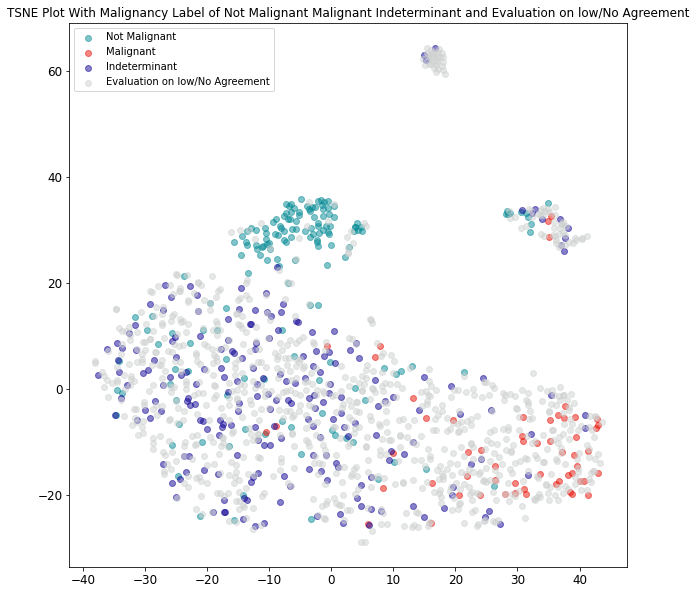

In [18]:
## Print tsne with class labels (spic/non-spic) for training and validation data 
radio_ids = df2['InstanceID'] #pandas dataframe
radio_ids2 = radio_ids.values #list
Bin_Rating = df2['Binary Rating']

spic_tsne = plt.figure(figsize=(10,10))

spic_classes = [0,1,2,3]

spic_colors = ['#048a94','#e81005','#100494','#cfd1d1'] # RED, BLUE   # 1 = Spiculated, 0 = Not Spiculated
spic_legend = ['Not Malignant','Malignant', 'Indeterminant','Evaluation on low/No Agreement']

agreement_inds = []
agreement_id = []

for i in spic_classes:
    inds = np.where(Bin_Rating==i)
    plt.scatter(X_embedded[inds, 0], X_embedded[inds,1], alpha=0.5, color=spic_colors[i])

plt.title('TSNE Plot With Malignancy Label of Not Malignant Malignant Indeterminant and Evaluation on low/No Agreement')                                                         # commented out title
plt.legend(spic_legend, fontsize=10, loc=2)
ax = plt.gca()
leg = ax.get_legend()

leg.legendHandles[0].set_color('#048a94')
leg.legendHandles[1].set_color('#e81005')
leg.legendHandles[2].set_color('#100494')
leg.legendHandles[3].set_color('#cfd1d1')

#plt.legend(handles=scatter.legend_elements()[0], labels=spic_legend, fontsize=17, loc=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#spic_tsne.savefig(name9, bbox_inches='tight')

(array([-40., -20.,   0.,  20.,  40.,  60.,  80.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

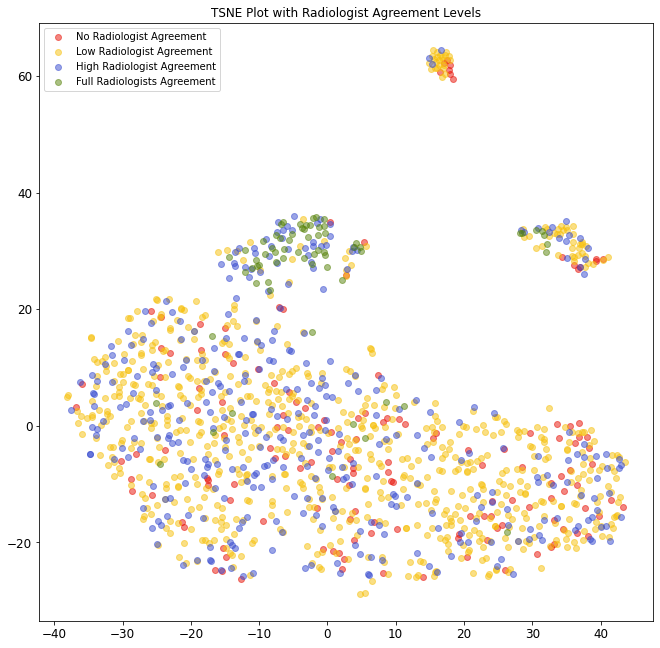

In [19]:
radio_ids = df2['InstanceID'] #pandas dataframe
radio_ids2 = radio_ids.values #list
agreements = df2['Agreement']
tsne_radio = plt.figure(figsize=(11,11))
radio_classes = [0, 1, 2, 3]
radio_names = ['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'Full Radiologists Agreement']

agreement_inds = []
agreement_id = []

for i in radio_classes:
    inds = np.where(agreements==i)
    plt.scatter(X_embedded[inds, 0], X_embedded[inds,1], alpha=0.5, color=radio_colors[i])
    ids = radio_ids2[inds]
    agreement_inds.append(inds)  # should be in the order of high agreement -> low agreement  # also, these are the index numbers
    agreement_id.append(ids)  # these are the instance id's
plt.title('TSNE Plot with Radiologist Agreement Levels')                                                                       # commented out title
#plt.title('(b)', fontweight="bold", fontsize=20, y=-0.1)
plt.legend(radio_names, fontsize=10, loc=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

1332


Text(0.5, 1.0, 'K-Means Clustering TSNE With 3 Clusters')

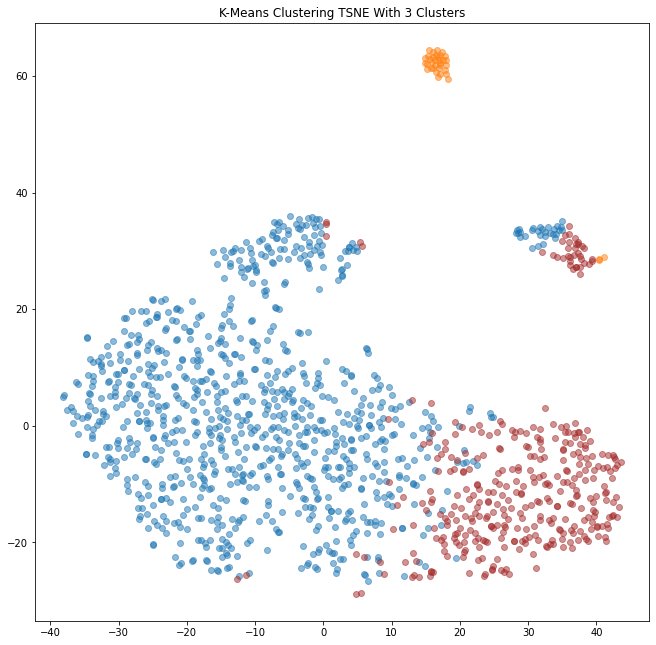

In [20]:
##### Run Kmeans clustering on the embeddings for ALL of the data ##### 

numbers = [3] #[2, 3, 4, 5, 6] #number of clusters
silhouette_total = []
wss_total = []
#sc = KMeans(n_clusters=numbers[0], random_state=0)

y_sc = sc.fit_predict(df_feature)
print(len(y_sc))
og_spectral = plt.figure(figsize=(11,11))
for i in range(numbers[0]):
    inds = np.where(y_sc==i)[0]
    plt.scatter(X_embedded[inds,0],X_embedded[inds,1],alpha=0.5, color=colors[i])
plt.title('K-Means Clustering TSNE With {} Clusters'.format(numbers[0]))


{0: 151, 1: 33, 2: 1148}


Text(0.5, 1.0, 'Spectral Clustering TSNE With 3 Clusters')

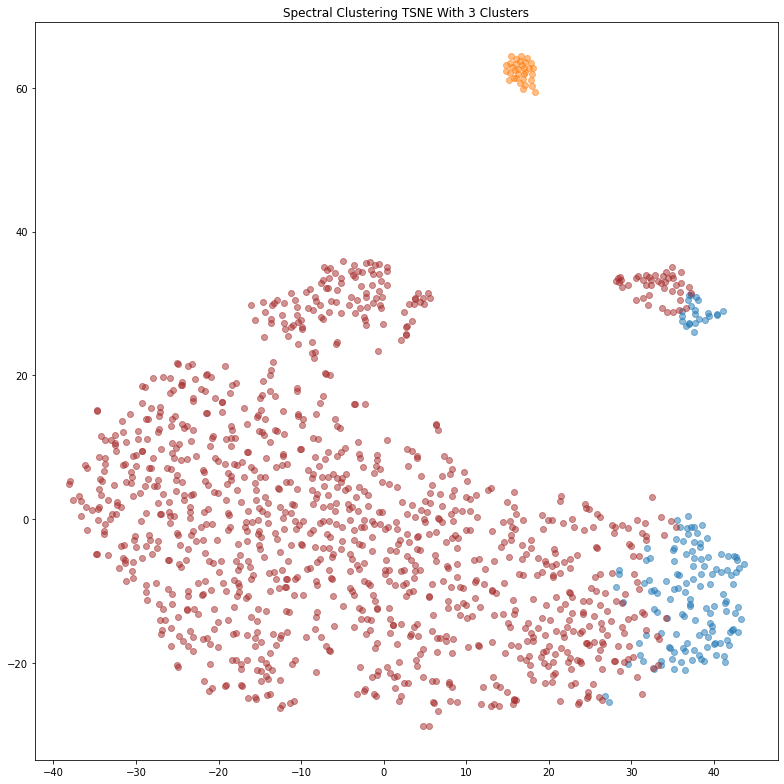

In [41]:

numbers = [3] #[2, 3, 4, 5, 6] #number of clusters
silhouette_total = []
wss_total = []

sc = SpectralClustering(n_clusters=numbers[0], random_state=0) 
y_sc = sc.fit_predict(df_feature)
#Conunt how many instances in each cluster
unique, counts = np.unique(y_sc, return_counts=True)
print(dict(zip(unique, counts)))
og_spectral = plt.figure(figsize=(11,11))
for i in range(numbers[0]):
    inds = np.where(y_sc==i)[0]
    plt.scatter(X_embedded[inds,0],X_embedded[inds,1],alpha=0.5, color=colors[i])
plt.title('Spectral Clustering TSNE With {} Clusters'.format(numbers[0]))


In [22]:
#Conunt how many instances in each cluster
unique, counts = np.unique(y_sc, return_counts=True)
print(dict(zip(unique, counts)))

{0: 933, 1: 36, 2: 363}


In [23]:
##### Data Analysis: WSS & Silhouette #####
# Calculate centroids and WSS
centroids = cluster_centroid(df_feature, y_sc, numbers[0])
wss_clusterlist, closest_ind_number, largest_ind_number = wss(centroids, df_feature, y_sc, numbers[0], 0) # only want the 0 highest and lowest points -- because the clusters are so small this is necessary for now
silhouette = silhouette_score(df_feature, y_sc, metric = 'euclidean', random_state=9)
wss_total.append(wss_clusterlist) # for the wss elbow plot 
silhouette_total.append(silhouette)

[   3    4    5    6    7    9   10   11   12   13   14   16   17   18
   19   20   21   22   23   28   29   33   34   35   36   38   39   41
   43   44   45   46   47   49   50   51   52   55   56   57   58   59
   60   62   63   64   65   68   71   72   74   76   77   78   79   80
   81   82   83   86   87   88   89   91   92   93   95   96   98  102
  104  106  107  108  115  117  118  119  123  124  125  126  127  130
  131  134  135  138  139  145  148  149  153  154  155  156  158  159
  160  161  162  163  164  165  166  172  173  174  178  179  180  181
  184  186  187  191  192  193  194  196  199  200  201  202  203  204
  205  206  207  208  209  210  211  213  214  216  217  218  220  221
  222  223  224  226  227  230  232  233  234  235  237  238  239  244
  245  246  248  249  250  251  253  254  255  258  261  262  263  264
  265  269  270  272  273  274  275  276  277  278  279  280  281  282
  283  285  286  287  288  289  290  291  294  295  296  299  300  301
  302 

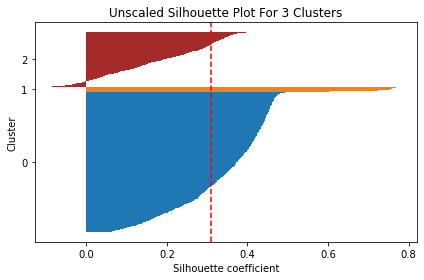

In [24]:
# First, do all silhouette work on the raw embeddings
silhouette_valsb4 = silhouette_samples(df_feature, y_sc, metric='euclidean') # get the silhouette value per sample
silhouette_avgb4 = silhouette_plt(y_sc, silhouette_valsb4, numbers[0], 0) # create and save the silhouette plot, and find the average of all of the silhouette scores
silhouette_clustersb4 = silhouette_cluster_average(y_sc, silhouette_valsb4, numbers[0])
sil_clusterb4_avg = np.mean(silhouette_clustersb4) # average all of the averaged silhouette cluster scores
stdclustersb4 = np.std(silhouette_clustersb4) # find the standard deviation of the averaged silhouette cluster scores
sil_clus_arrayb4 = silhouette_cluster_array(y_sc, silhouette_clustersb4) # make the silhouette cluster an array corresponding to the image numbers

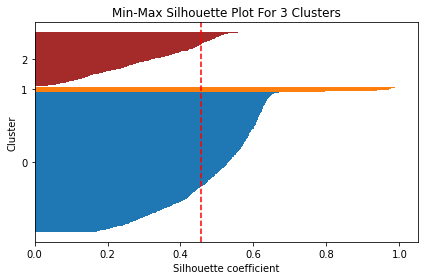

In [25]:
# Min Max all of the silhouette values, then repeat 
scaler = MinMaxScaler()
silhouette_vals = scaler.fit_transform(silhouette_valsb4.reshape(-1,1))
silhouette_vals = silhouette_vals.flatten()
sil_avg_minmax = silhouette_plt(y_sc, silhouette_vals, numbers[0], 1)
silhouette_clusters = silhouette_cluster_average(y_sc, silhouette_vals, numbers[0])
sil_cluster_avg = np.mean(silhouette_clusters)
stdclusters = np.std(silhouette_clusters)  
sil_clus_array = silhouette_cluster_array(y_sc, silhouette_clusters)

In [26]:
# Apply the reverse metric to the silhouette coefficients 
rev_silhouette_vals = silhouette_vals  
actual_silhouette_vals = 1 - silhouette_vals

# Take the average of the scaled silhouette values
scaler = MinMaxScaler() 
ci_avg = 1 - np.array([np.mean(k) for k in zip(silhouette_vals, sil_clus_array)])  ##  < to switch the metric backwards
ci_avg2 = np.array([np.mean(k) for k in zip(silhouette_vals, sil_clus_array)])  ## < for original metric (comparable to KNN)

# Multiply the scaled silhouette values
ci = 1 - (np.multiply(silhouette_vals, sil_clus_array))  ##  < to switch the metric backwards
ci_norm = scaler.fit_transform(ci.reshape(-1,1)) #< min max the confidence interval values
ci_norm = ci_norm.reshape(len(y_sc))
ci2 = np.multiply(silhouette_vals, sil_clus_array)  ##  < for original metric (comparable to KNN)
ci2_norm = scaler.fit_transform(ci2.reshape(-1,1)) #< min max the confidence interval values
ci2_norm = ci2_norm.reshape(len(y_sc)) 

In [27]:
# Save histograms for the metrics
def save_hist(data, numclusters):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(data, color="black")
    ax.set_title('Silhouette Coefficients Histogram')
    ax.set_xlabel('Silhouette Coefficients Values')
    ax.set_ylabel('Frequency')
    #ax.set_xticks(minor=False)
    fig.tight_layout()
    #fig.savefig("test case {}/{} cluster/Histogram - {}.png".format(run, numclusters, filename), format='png')
    plt.show(fig)

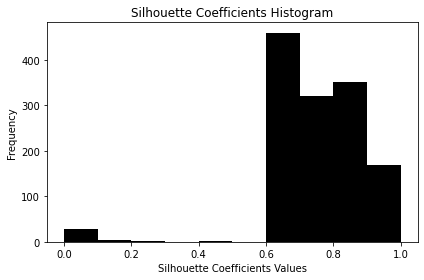

In [28]:
## Plot histograms for the metrics 
list_of_metrics = [ci_norm]       
#list_of_metrics = [actual_silhouette_vals, ci_avg, ci_norm]  
for q in range(len(list_of_metrics)):
    save_hist(list_of_metrics[q], numbers[0])

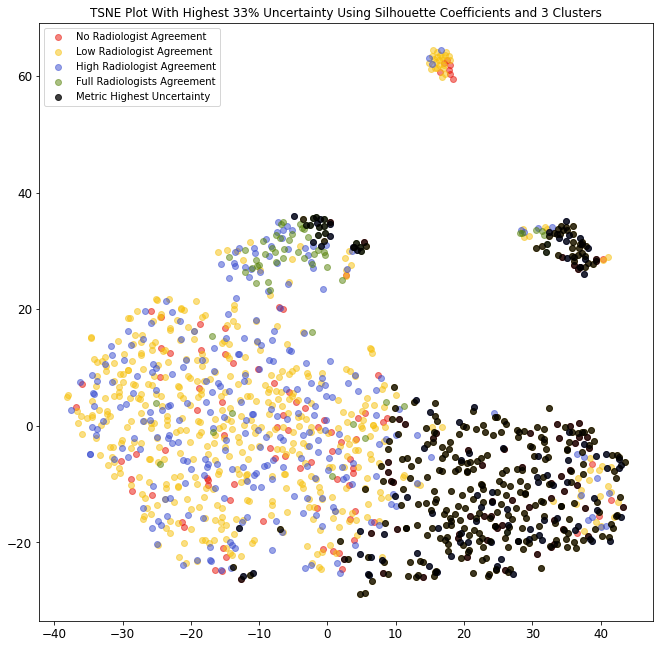

In [29]:
for m in range(len(list_of_metrics)):
    newlegend = ['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'Full Radiologists Agreement', 'Metric Highest Uncertainty']
    newlistnum = [441] #33% #[353, 706] #25%, 50%
    for r in newlistnum:
        indlargest = np.argpartition(list_of_metrics[m], -r)[-r:]
        new1 = plt.figure(figsize=(11,11))
        for i in radio_classes:
            inds = np.where(agreements==i)
            plt.scatter(X_embedded[inds, 0], X_embedded[inds,1], alpha=0.5, color=radio_colors[i]) 
        for k in indlargest:
            plt.scatter(X_embedded[k,0], X_embedded[k,1], alpha=0.75, color = 'black')
        title2 = 'TSNE Plot With Highest {}% Uncertainty Using {}and {} Clusters'.format(str(round(r/(len(y_sc))*100)), metric_names[m], numbers[0])
        plt.title(title2)                                                                                                                              # commented out title    
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(newlegend, fontsize=10, loc=2)
        plt.show()

In [30]:
total_ids = df2['InstanceID']
spic_ids = df2['InstanceID'].tolist()
spic_tr_val = df2['Binary Rating'].tolist()
vis_tr_te = df2['Agreement'].tolist()

In [31]:
##### Highest Uncertainty Points #####
## obtain highest uncertainty indices 
unc_index = np.argpartition(ci_norm, -1332)[-1332:] 
unc_values = ci_norm[unc_index]
unc_ids = total_ids[unc_index]
unc_imgs = df_feature[unc_index]

# fix the agreement id variable to be iterable...
agreement_id2 = []
agreement_levels = []
counter = 0
for a in agreement_id:
    for k in a:
        agreement_id2.append(k)
        agreement_levels.append(counter)
    counter += 1

# retrieve vals for specific ids (highest uncertainty ids)
uncertainty_agreement = []
uncertainty_names = []

for k in unc_ids:
    agr_index = agreement_id2.index(k)
    unc_agr = agreement_levels[agr_index]
    unc_agr2= radio_names[unc_agr]

    uncertainty_agreement.append(unc_agr)
    uncertainty_names.append(unc_agr2)

######### ---Amal--- #########

## get spiculation rating for each image
spic_rate = []
instance_id = []
for j in unc_ids:
    if j in spic_ids:
        spic_index = spic_ids.index(j)
        spic_r = spic_tr_val[spic_index]
        spic_rate.append(spic_r)
        instance_id.append(j)

######### ---Amal--- #########


## print out each image
counter = 0

#To get uncertinaty scores for distrbution
num = []
agre = []
siz = []
spic = []
inst_id = []

for l in range(len(unc_imgs)):
    actual_unc = unc_values[l]
    num.append(actual_unc)
    unc_name = uncertainty_names[l]
    agre.append(unc_name)
    spic_unc = spic_rate[l]
    spic.append(spic_unc)
    id_inst = instance_id[l]
    inst_id.append(id_inst)

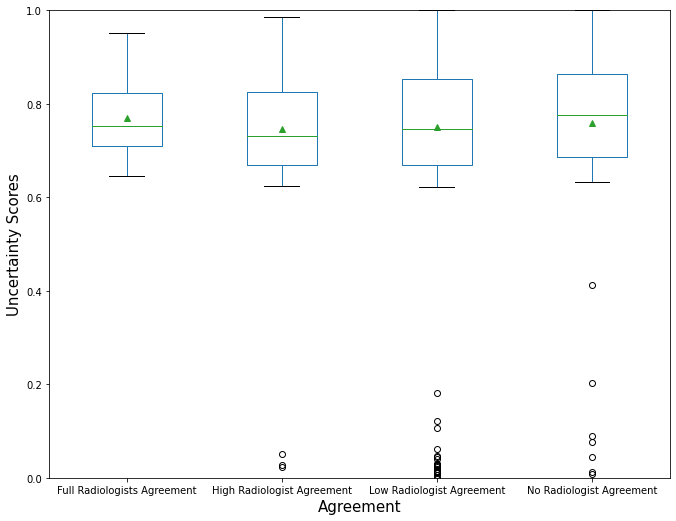

In [32]:
data = {'InstanceID': inst_id,
        'Score': num,
        'Agreement': agre,
        'Spiculation':spic}
        #'Category': cat_t}

# Convert the dictionary into DataFrame
df = pd.DataFrame(data)
df.to_csv("/Users/amalalmansour/Desktop/New_Images/Malignancy/DF_mal_max_scores_kmeans.csv")

plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))

axes = df.boxplot(by='Agreement',column =['Score'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
plt.ylim([0.0, 1.0])
plt.ylabel("Uncertainty Scores", fontdict={'fontsize':15})
plt.xlabel("Agreement", fontdict={'fontsize':15})
plt.show()

In [33]:
m2 = df.groupby(['Agreement'])['Score'].mean().values
print(m2)

[0.76851395 0.74552933 0.75008358 0.75943396]


In [34]:
m1 = df.groupby(['Agreement'])['Score'].median().values
print(m1)

[0.75177126 0.730342   0.74489831 0.77646445]


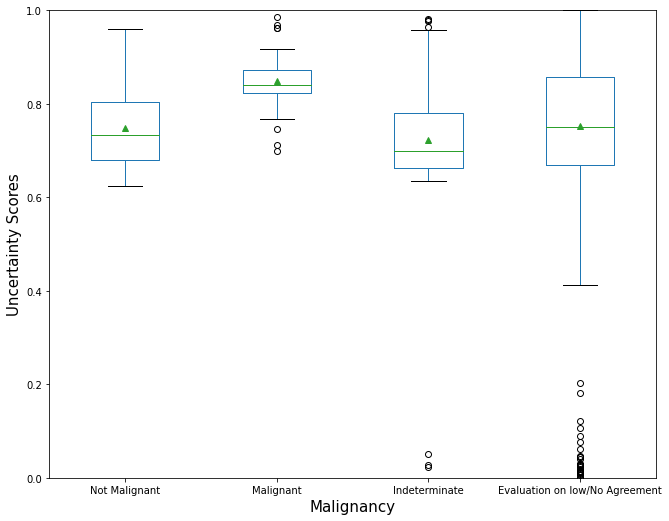

In [35]:
plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))

axes = df.boxplot(by='Spiculation',column =['Score'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
plt.ylim([0.0, 1.0])
plt.ylabel("Uncertainty Scores", fontdict={'fontsize':15})
plt.xlabel("Malignancy", fontdict={'fontsize':15})
plt.xticks([1, 2, 3,4], ['Not Malignant','Malignant', 'Indeterminate','Evaluation on low/No Agreement'])
plt.show()

In [36]:
m1 = df.groupby(['Spiculation'])['Score'].mean().values
print(m1)

[0.74811    0.84831782 0.72286558 0.75162303]


In [37]:
m1 = df.groupby(['Spiculation'])['Score'].median().values
print(m1)

[0.73320879 0.83975936 0.69881606 0.75127005]


([<matplotlib.axis.XTick at 0x167ab7790>,
 [Text(1, 0, 'Not Malignant\nAll Radiologists Agree'),
  Text(2, 0, 'Not Malignant\nHigh Radiologist Agreement'),
  Text(3, 0, 'Malignant\nAll Radiologists Agree'),
  Text(4, 0, 'Malignant\nHigh Radiologist Agreement'),
  Text(5, 0, 'Indeterminant\nAll Radiologists Agree'),
  Text(6, 0, 'Indeterminant\nHigh Radiologist Agreement'),
  Text(7, 0, 'Low Radiologist Agreement'),
  Text(8, 0, 'No Radiologist Agreement')])

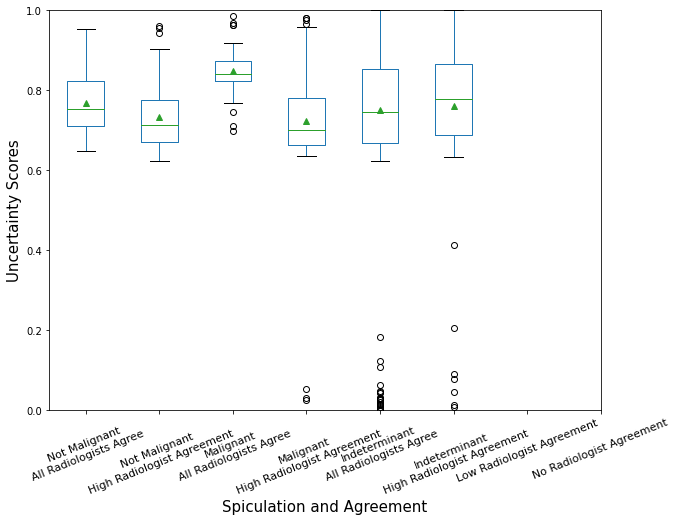

In [38]:
plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))
#newlegend1 = ['Not Malignant', 'Malignant','Indeterminant', 'Unknown']
axes = df.boxplot(by=['Spiculation','Agreement'], column =['Score'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
plt.ylim([0.0, 1.0])
plt.ylabel("Uncertainty Scores",fontdict={'fontsize':15})
plt.xlabel("Spiculation and Agreement",fontdict={'fontsize':15})
#plt.xticks([1, 2, 3, 4,5,6], ["Not Spiculated\nAll Radiologists Agree", "Not Spiculated\nHigh Radiologist Agreement", "Spiculated\nAll Radiologists Agree", "Spiculated\nHigh Radiologist Agreement", "Evaluation on low Agreement", "Evaluation on No Agreement"], rotation=12, fontsize=10)
plt.xticks([1, 2, 3, 4,5,6,7,8], ["Not Malignant\nAll Radiologists Agree", "Not Malignant\nHigh Radiologist Agreement", "Malignant\nAll Radiologists Agree", "Malignant\nHigh Radiologist Agreement", "Indeterminant\nAll Radiologists Agree", "Indeterminant\nHigh Radiologist Agreement", "Low Radiologist Agreement", "No Radiologist Agreement"], rotation=22, fontsize=11)
#plt.xticks([1, 2, 3], ['Not Spiculated', 'Spiculated', 'Unknown'])

In [39]:
m1 = df.groupby(['Spiculation','Agreement'])['Score'].describe()
print(m1)

                                         count      mean       std       min  \
Spiculation Agreement                                                          
0           Full Radiologists Agreement   68.0  0.768514  0.078522  0.646426   
            High Radiologist Agreement    94.0  0.733350  0.080620  0.623408   
1           High Radiologist Agreement    57.0  0.848318  0.054725  0.698219   
2           High Radiologist Agreement   208.0  0.722866  0.121530  0.023668   
3           Low Radiologist Agreement    756.0  0.750084  0.163957  0.000000   
            No Radiologist Agreement     149.0  0.759434  0.174293  0.007785   

                                              25%       50%       75%  \
Spiculation Agreement                                                   
0           Full Radiologists Agreement  0.709006  0.751771  0.822697   
            High Radiologist Agreement   0.669600  0.712566  0.775864   
1           High Radiologist Agreement   0.823162  0.839759  0.8719

In [40]:
m1 = df.groupby(['Spiculation','Agreement'])['Score'].median().values
print(m1)

[0.75177126 0.71256612 0.83975936 0.69881606 0.74489831 0.77646445]
